To detect negative speech in tweets.

## Dataset : 
The data set contains tweets and sentiment related to it. Here we need to predict the sentiment for a given tweet.
Here, in label 
* __label “0”: Positive Sentiment__ 
* __label “1”: Negative Sentiment__  

## Step 1 : Import libraries

Here we are gonna use NLTK, i.e., Natural Language Tool Kit
As name suggests, it is contains all the modules required for NLP operations.
In this problem, as we are dealing with statements, NLTK suits well.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import nltk
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.pipeline import make_pipeline
import warnings 
warnings.filterwarnings("ignore")
import pickle
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
from nltk.tokenize import regexp_tokenize 
from sklearn import model_selection, naive_bayes, svm
from sklearn.ensemble import RandomForestClassifier
import re

[nltk_data] Downloading package wordnet to /home/akanksha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Step 2: Import datasets

Read the data with pandas.
* __train.csv__ : It contains tweets with its corresponding sentiment. We'll use this to train our model to predict the sentiment behind the tweet.

* __test.csv__ : It contains the data we are gonna use to test our model.


In [2]:
train  = pd.read_csv("twitter-sentiment-analysis/train.csv")
test = pd.read_csv("twitter-sentiment-analysis/test.csv")
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


## Over sampling

## Step 3 : Data cleaning and Preprocessing

### __Lemmating__ and __Tokenization__

In [3]:
class Cleanup:
    def lemmatizeation(self, data):

        stop_words = set(stopwords.words('english'))

        lemma_function = WordNetLemmatizer()

        sentence = []
        for text in data:
            lemma = []
            tokens = regexp_tokenize(text, "[#\w']+") 
            for token in tokens:
                if (token not in stop_words) and (not token.startswith('@')):
                    lemma.append(lemma_function.lemmatize(token))

            val = ' '
            for word in lemma:
                val = val + " "+word 
            sentence.append(val.strip())
        return sentence 


clean = Cleanup()
train['cleaned_tweet'] = clean.lemmatizeation(train.tweet.values)
test['cleaned_tweet'] = clean.lemmatizeation(test.tweet.values)


In [4]:
print(train['tweet'].iloc[1])
print(train['cleaned_tweet'].iloc[1])

@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
user user thanks #lyft credit can't use cause offer wheelchair van pdx #disapointed #getthanked


### Hashtags
Graph to show normal tweets. Check top 20 most used hashtags and plot them according to their frequency

In [5]:
#Select all words from normal tweet
normal_words = ' '.join([word for word in train['cleaned_tweet'][train['label'] == 0]])
#Collect all hashtags
pos_htag = [htag for htag in normal_words.split() if htag.startswith('#')]
#Remove hashtag symbol (#)
pos_htag = [pos_htag[i][1:] for i in range(len(pos_htag))]
#Count frequency of each word
pos_htag_freqcount = nltk.FreqDist(pos_htag)
pos_htag_df = pd.DataFrame({'Hashtag' : list(pos_htag_freqcount.keys()),
                            'Count' : list(pos_htag_freqcount.values())})

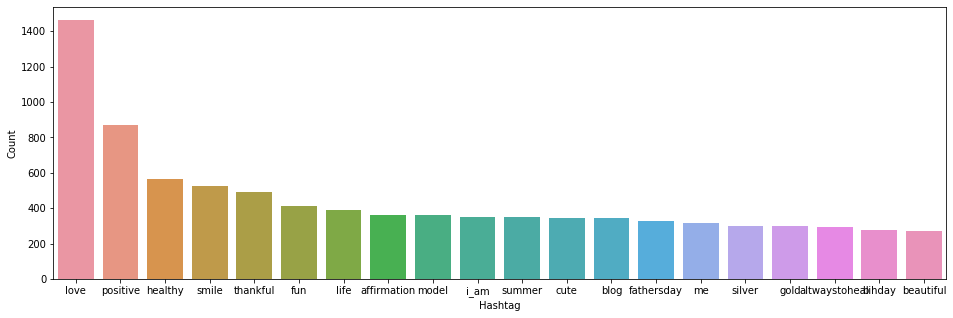

In [6]:
#Select top 20 most frequent hashtags and plot them   
most_frequent = pos_htag_df.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=most_frequent, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

Graph to show negative tweets. In negative tweets, 20 hashtags that appeared the most is shown in graph.

In [7]:
#Repeat same steps for negative tweets
negative_words = ' '.join([word for word in train['cleaned_tweet'][train['label'] == 1]])
neg_htag = [htag for htag in negative_words.split() if htag.startswith('#')]
neg_htag = [neg_htag[i][1:] for i in range(len(neg_htag))]
neg_htag_freqcount = nltk.FreqDist(neg_htag)
neg_htag_df = pd.DataFrame({'Hashtag' : list(neg_htag_freqcount.keys()),
                            'Count' : list(neg_htag_freqcount.values())})

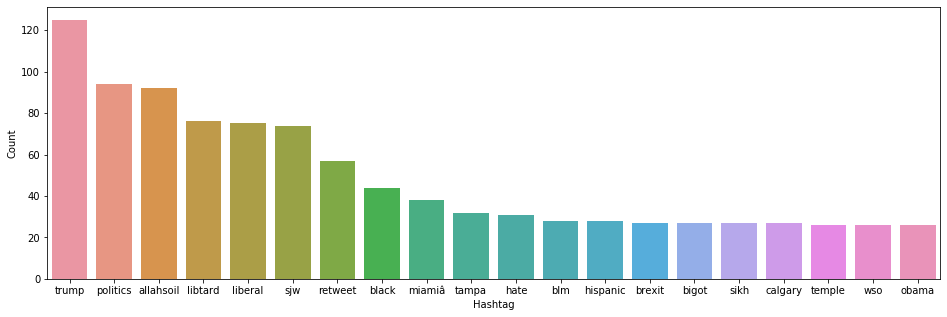

In [8]:
most_frequent = neg_htag_df.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=most_frequent, x= "Hashtag", y = "Count")
plt.show()

From both plots, we can conclude that hashtags are very important for sentiment analysis and should not be ignored.

Words used like love, friend, happy are used in normal tweets whereas negative can be found in words like trump, black, politics etc.

In [9]:
train.head(2)

,id,label,tweet,cleaned_tweet
0,1,0,@user when a father is dysfunctional and is s...,user father dysfunctional selfish drag kid dys...
1,2,0,@user @user thanks for #lyft credit i can't us...,user user thanks #lyft credit can't use cause ...


In [10]:
X_train, X_val, y_train, y_val = train_test_split(train['cleaned_tweet'], train['label'], random_state = 0)
X_train.shape, X_val.shape

((23971,), (7991,))

# Step 4 : Model Creation

## Applying Bag-of-Words

Rescale data using CountVectorizer
# __CountVectorizer__
It’ll see the unique words in the complete para or content given to it and then does one hot encoding accordingly. CountVectorization generates a sparse matrix representing all the words in the document. 

In [11]:
cv = CountVectorizer()
cv.fit(X_train)
x_val = cv.transform(X_val)
X_train_vectorized = cv.transform(X_train)

In [12]:
X_train_vectorized

<23971x33239 sparse matrix of type '<class 'numpy.int64'>'
	with 190391 stored elements in Compressed Sparse Row format>

### Naive Bayes

In [13]:
naive_base_model_cv = MultinomialNB()
naive_base_model_cv.fit(X_train_vectorized, y_train)
pred = naive_base_model_cv.predict(x_val)
print('F1 :', f1_score(y_val, pred))

F1 : 0.6324786324786325


### Logistic Regression

In [14]:
logistic_model_cv = LogisticRegression()
logistic_model_cv.fit(X_train_vectorized, y_train)
pred = logistic_model_cv.predict(x_val)
print('F1 :', f1_score(y_val, pred))

F1 : 0.64


### SVM

In [15]:
SVM_cv = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM_cv.fit(X_train_vectorized, y_train)
pred = SVM_cv.predict(x_val)
print('F1 :', f1_score(y_val, pred))

F1 : 0.6982124079915878


### Random Forest

In [17]:
# Fitting Random Forest Classification to the Training set
random_forest_cv = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
random_forest_cv.fit(X_train_vectorized, y_train)
# Predicting the Test set results
pred = random_forest_cv.predict(x_val)
print('F1 :', f1_score(y_val, pred))

F1 : 0.589242053789731


Logistic Regression performed well then Naive Bayes for the default parameters. Thus, we will be using only Logistic Regression ahead.

# __Tfidf__
 This one is similar to countvectorizer, however it removes the stopwords and stores the important words which might be used less but gives us more better features.And stores the frequency of the words.

In [18]:
# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 5
tf = TfidfVectorizer()
tf.fit(X_train)
x_val = tf.transform(X_val)
print('Total Features =', len(tf.get_feature_names()))
X_train_vectorized = tf.transform(X_train)

Total Features = 33239


### Naive Bayes

In [19]:
naive_base_model_tf = MultinomialNB()
naive_base_model_tf.fit(X_train_vectorized, y_train)
pred = naive_base_model_tf.predict(x_val)
print('F1 :', f1_score(y_val, pred))

F1 : 0.22408026755852845


### Logistic Regression

In [20]:
logistic_model_tf = LogisticRegression()
logistic_model_tf.fit(X_train_vectorized, y_train)
pred = logistic_model_tf.predict(x_val)
print('F1: ', f1_score(y_val, pred))

F1:  0.43165467625899284


### SVM

In [21]:
SVM_tf = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM_tf.fit(X_train_vectorized, y_train)
# predict the labels on validation dataset
pred = SVM_tf.predict(x_val)
# Use accuracy_score function to get the accuracy
print('F1 :', f1_score(y_val, pred))

F1 : 0.6523297491039427


### Random Forest

In [23]:
# Fitting Random Forest Classification to the Training set
random_forest_tf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
random_forest_tf.fit(X_train_vectorized, y_train)
# Predicting the Test set results
pred = random_forest_tf.predict(x_val)
print('F1 :', f1_score(y_val, pred))

F1 : 0.5520833333333334


# Step : Test the model 

tf-idf not performed well for this data.

In [36]:
my_tweet = [test.tweet.iloc[1]]
stop_words = set(stopwords.words('english'))
print(my_tweet)
cleaned_tweet = clean.lemmatizeation(my_tweet)
print(cleaned_tweet)
x = cv.transform(cleaned_tweet)
SVM_cv.predict(x)

[' @user #white #supremacists want everyone to see the new â\x80\x98  #birdsâ\x80\x99 #movie â\x80\x94 and hereâ\x80\x99s why  ']
['user #white #supremacists want everyone see new â #birdsâ #movie â hereâ']


array([0])